In [1]:
!pip install torch torchvision matplotlib pillow



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Grace\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt


In [24]:


import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class BottleSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.replace('.png', '_mask.png')
        mask_path = os.path.join(self.mask_dir, mask_name)
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Grayscale mask

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask




In [25]:
image_dir = r"C:\Users\Grace\Downloads\bottle\bottle\test\broken_large"
mask_dir = r"C:\Users\Grace\Downloads\bottle\bottle\ground_truth\broken_large"
dataset = BottleSegmentationDataset(image_dir, mask_dir, transform, mask_transform)


In [26]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU(),
            nn.Conv2d(16, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3



In [27]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [28]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")



Epoch [1/5], Loss: 0.7452
Epoch [2/5], Loss: 0.7128
Epoch [3/5], Loss: 0.5447
Epoch [4/5], Loss: 0.3292
Epoch [5/5], Loss: 0.3503


In [29]:
import os

image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)
print("Sample image files:", image_files[:5])
print("Sample mask files:", mask_files[:5])



Sample image files: ['000.png', '001.png', '002.png', '003.png', '004.png']
Sample mask files: ['000_mask.png', '001_mask.png', '002_mask.png', '003_mask.png', '004_mask.png']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6212862..2.64].


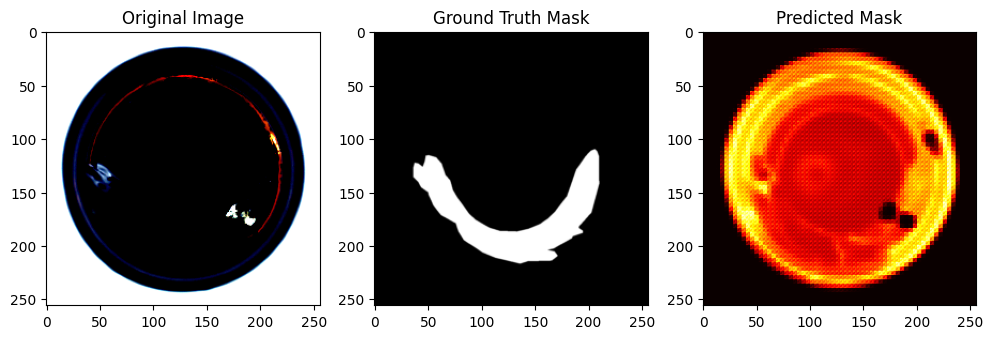

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5870366..2.64].


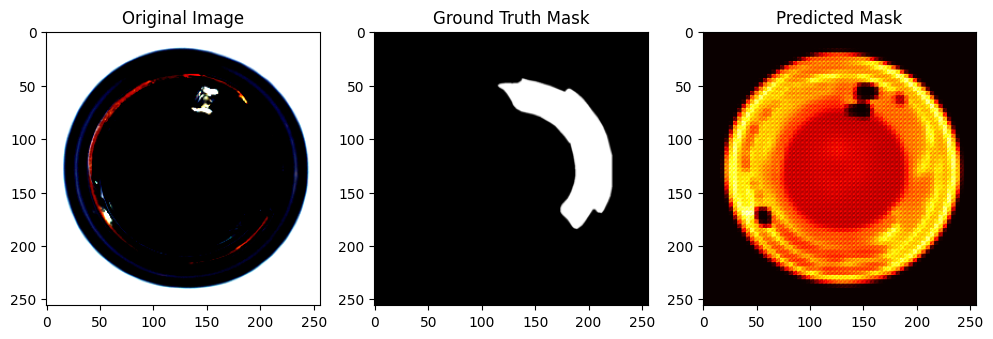

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..2.64].


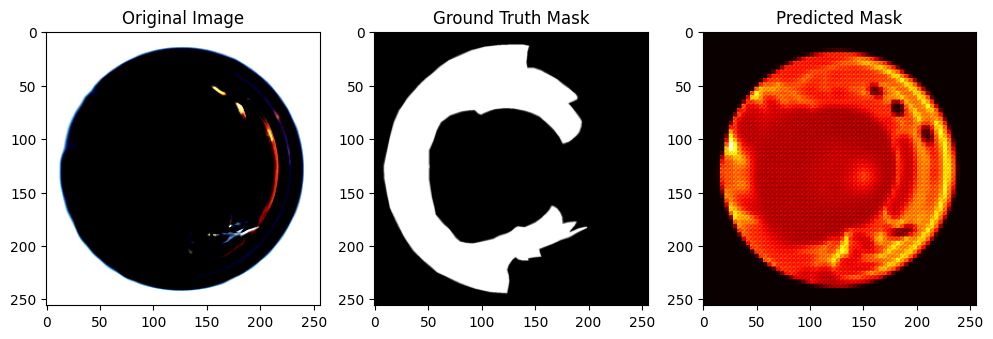

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..2.64].


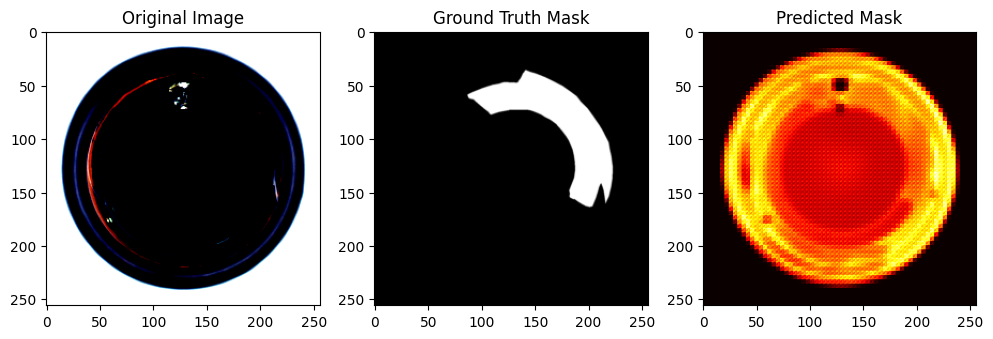

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5699118..2.64].


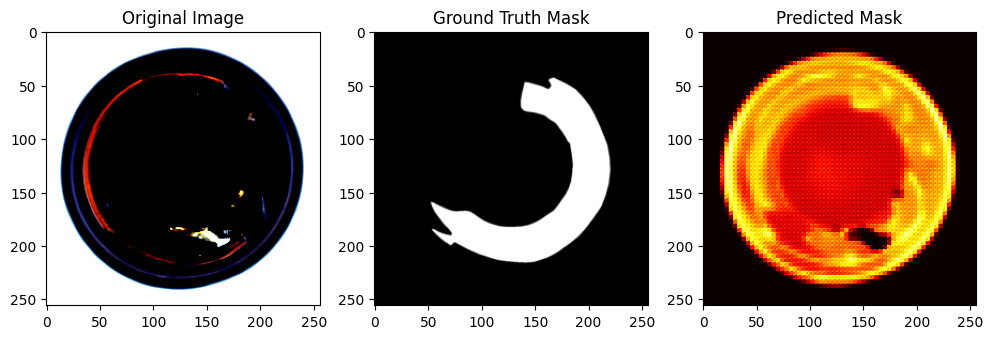

In [30]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for i, (image, mask) in enumerate(dataloader):
        image = image.to(device)
        output = model(image)
        pred_mask = output[0, 0].cpu().numpy()
        true_mask = mask[0, 0].cpu().numpy()
        orig_img = image[0].permute(1,2,0).cpu().numpy()

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(orig_img)
        axs[0].set_title("Original Image")
        axs[1].imshow(true_mask, cmap='gray')
        axs[1].set_title("Ground Truth Mask")
        axs[2].imshow(pred_mask, cmap='hot')
        axs[2].set_title("Predicted Mask")
        plt.show()
        if i == 4:
            break


In [31]:
import numpy as np

def calculate_accuracy(pred_mask, true_mask, threshold=0.5):
    pred_bin = (pred_mask > threshold).astype(np.uint8)
    true_bin = (true_mask > threshold).astype(np.uint8)
    correct = (pred_bin == true_bin).sum()
    total = pred_bin.size
    return correct / total

# Usage for a single image:
accuracy = calculate_accuracy(pred_mask, true_mask)
print(f"Accuracy: {accuracy:.3f}")


Accuracy: 0.853
